In [1]:
%%capture
!pip install torch
!pip install torchvision
!pip install torchmetrics pytorch-fid
!pip install torchmetrics[image]
!pip install torch-fidelity

In [2]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch import nn
from tqdm import tqdm
from torchsummary import summary
from torchmetrics.image.inception import InceptionScore
from torchmetrics.image.fid import FrechetInceptionDistance
from torchvision import models

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
training_data = datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

test_data = datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform
)

train_dataloader = DataLoader(training_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 14.6MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 452kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.50MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 1.21MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
print("Number train set: ", len(training_data))
print("Number test set: ", len(test_data))

Number train set:  60000
Number test set:  10000


In [5]:
class CNNGenerator(nn.Module):
    def __init__(self):
        super(CNNGenerator, self).__init__()
        self.layers = nn.Sequential(
            # Input: Z(100)
            nn.Unflatten(1, (100, 1, 1)),

            # R(1,1,100)
            # No layer required for reshape operation

            # CONVT(128,3,1), BN
            nn.ConvTranspose2d(100, 128, kernel_size=3, stride=1, bias=False, padding=0),  #output 3x3
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # CONVT(64,3,2), BN
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, bias=False, padding=0), #output 7x7
            nn.BatchNorm2d(64),
            nn.ReLU(),

            # CONVT(32,3,2), BN
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, bias=False, padding=1, output_padding=1), #output 14x14
            nn.BatchNorm2d(32),
            nn.ReLU(),

            # CONVT(1,3,2)
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, bias=False, padding=1, output_padding=1), #output 28x28
            nn.Tanh()
        )

    def forward(self, x):
        # print("Generator Input shape:", x.shape)
        for layer in self.layers:
            x = layer(x)
            # print(f"{layer.__class__.__name__} output shape: {x.shape}")
        return x


class CNNDiscriminator(nn.Module):
    def __init__(self):
        super(CNNDiscriminator, self).__init__()
        self.layers = nn.Sequential(
            # Input: (28,28,1)

            # CONV(32,3,2), BN, LReLU
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),

            # CONV(64,3,2), BN, LReLU
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            # CONV(128,3,2), BN, LReLU
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            # CONV(1,3,1)
             nn.Conv2d(128, 1, kernel_size=3, stride=1, padding=0, bias=False),
             nn.Flatten(),
              nn.Linear(4, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        #  print("Discriminator Input shape:", x.shape)
         for layer in self.layers:
             x = layer(x)
            #  print(f"{layer.__class__.__name__} output shape: {x.shape}")
         return x



In [6]:
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
generator = CNNGenerator()
discriminator = CNNDiscriminator()
#Define BCE Loss
bce_loss = nn.BCELoss()

#Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002)


In [8]:
generator.to(device)
discriminator.to(device)

CNNDiscriminator(
  (layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2)
    (9): Conv2d(128, 1, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Linear(in_features=4, out_features=1, bias=True)
    (12): Sigmoid()
  )
)

Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 117MB/s]
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch [1/20] | D Loss: 0.0065 | G Loss: 8.6785 


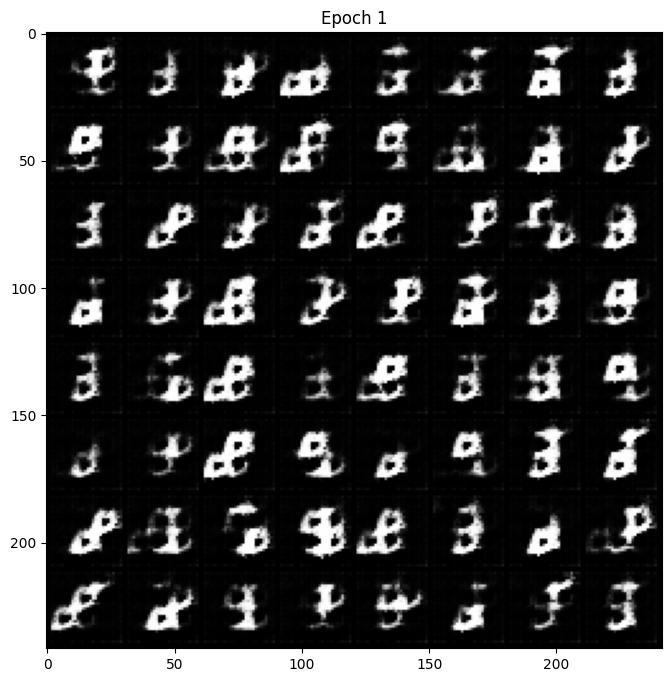

Epoch [2/20] | D Loss: 0.0074 | G Loss: 8.0146 


Epoch [3/20] | D Loss: 0.1490 | G Loss: 5.8476 


Epoch [4/20] | D Loss: 0.3392 | G Loss: 3.5826 


Epoch [5/20] | D Loss: 0.2210 | G Loss: 2.5300 


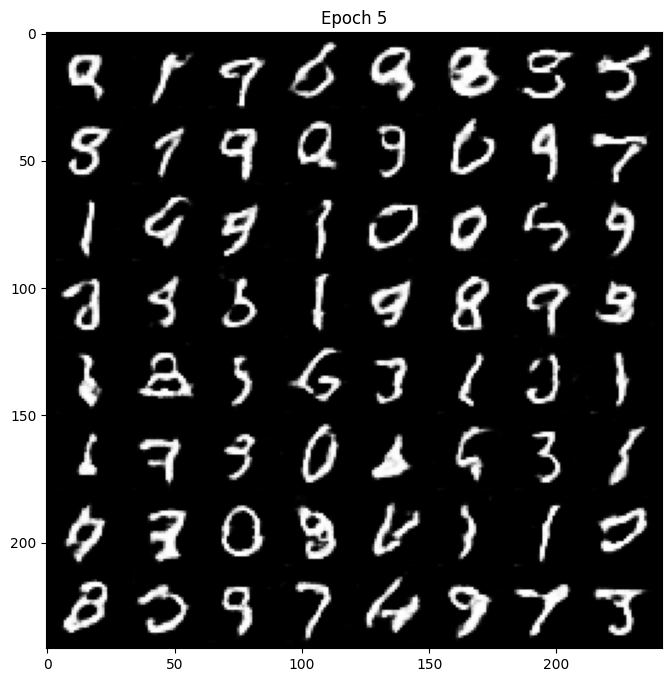

Epoch [6/20] | D Loss: 0.4139 | G Loss: 1.1172 


Epoch [7/20] | D Loss: 0.3516 | G Loss: 1.2513 


Epoch [8/20] | D Loss: 0.1327 | G Loss: 3.9558 


Epoch [9/20] | D Loss: 0.4805 | G Loss: 2.4966 


Epoch [10/20] | D Loss: 0.3931 | G Loss: 1.5528 


Epoch [11/20] | D Loss: 0.0382 | G Loss: 4.3010 


Epoch [12/20] | D Loss: 0.6562 | G Loss: 2.0972 


Epoch [13/20] | D Loss: 0.2623 | G Loss: 2.8313 


Epoch [14/20] | D Loss: 0.4332 | G Loss: 1.4732 


Epoch [15/20] | D Loss: 0.2455 | G Loss: 4.4861 


Epoch [16/20] | D Loss: 0.3321 | G Loss: 5.5232 


Epoch [17/20] | D Loss: 0.0773 | G Loss: 4.5549 


Epoch [18/20] | D Loss: 0.6077 | G Loss: 2.2018 


Epoch [19/20] | D Loss: 0.0926 | G Loss: 4.1227 


Epoch [20/20] | D Loss: 1.2931 | G Loss: 1.1212 


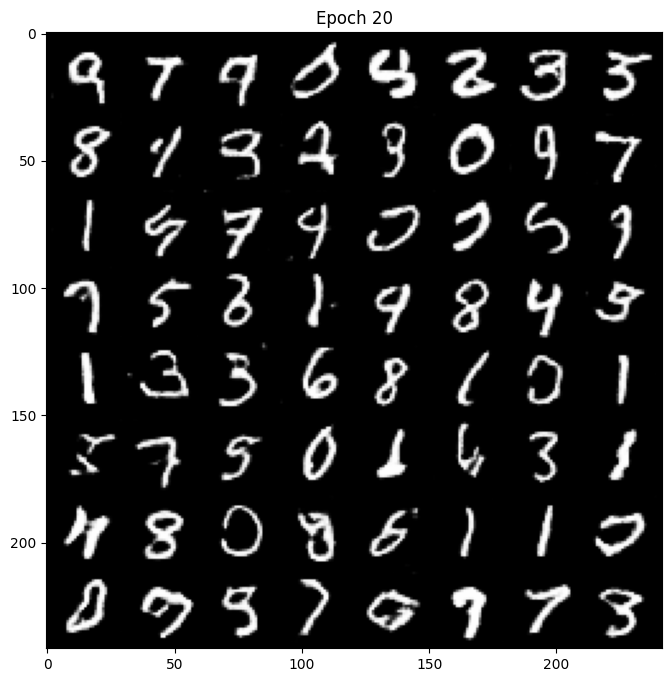

In [9]:
# Parameters
num_epochs = 20
latent_dim = 100
fixed_noise = torch.randn(64, latent_dim).to(device)
# Initialize FID and Inception Score
fid = FrechetInceptionDistance(feature=2048).to(device) # Default Feature is 2048
inception = InceptionScore().to(device)

for epoch in range(num_epochs):
    epoch_progress = tqdm(train_dataloader, desc=f"Epoch [{epoch+1}/{num_epochs}]", leave=False)

    for batch_idx, (real_images, _) in enumerate(epoch_progress):
        # TRAIN DISCRIMINATOR
        real_images = real_images.to(device)
        batch_size = real_images.size(0)

        # Label thật và giả
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Tính loss với ảnh thật
        real_outputs = discriminator(real_images)
        d_loss_real = bce_loss(real_outputs, real_labels)

        # Sinh ảnh giả
        noise = torch.randn(batch_size, latent_dim).to(device)
        fake_images = generator(noise)

        # Tính loss với ảnh giả
        fake_outputs = discriminator(fake_images)
        d_loss_fake = bce_loss(fake_outputs, fake_labels)

        d_loss = d_loss_real + d_loss_fake

        # Cập nhật Discriminator
        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

        # TRAIN GENERATOR
        # Sinh lại ảnh giả
        fake_images = generator(noise)
        # Tính loss của G
        fake_outputs = discriminator(fake_images)
        g_loss = bce_loss(fake_outputs, real_labels)

        # Cập nhật Generator
        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

        # Cập nhật tqdm progress bar
        epoch_progress.set_postfix(D_Loss=f"{d_loss.item():.4f}", G_Loss=f"{g_loss.item():.4f}")


    tqdm.write(f"Epoch [{epoch+1}/{num_epochs}] | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f} ")

    # Save generated images for visualization
    if (epoch + 1) in {1, 5, 20}:
        with torch.no_grad():
            fake_images = generator(fixed_noise)
            grid = torchvision.utils.make_grid(fake_images, nrow=8, normalize=True)
            plt.figure(figsize=(8, 8))
            plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
            plt.title(f"Epoch {epoch+1}")
            plt.show()



In [10]:
torch.cuda.empty_cache()

In [11]:
real_images

tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        ...,


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., 

In [12]:
num_epochs = 10
for epoch in range(num_epochs):
    with torch.no_grad():
        batch_size = 16
        num_samples = 1000
        for _ in range(num_samples // batch_size):
            noise_eval = torch.randn(batch_size, latent_dim).to(device)
            fake_images = generator(noise_eval)

            # Convert to 3 channels
            fake_images_3channel = fake_images.repeat(1, 3, 1, 1)
            real_images_3channel = real_images[:batch_size].repeat(1, 3, 1, 1).to(device)

            fid.update(real_images_3channel.to(torch.uint8), real=True)
            fid.update(fake_images_3channel.to(torch.uint8), real=False)
            inception.update(fake_images_3channel.to(torch.uint8))

        fid_score = fid.compute()
        inception_score, inception_std = inception.compute()

        print(f"Epoch [{epoch+1}/{num_epochs}] | FID: {fid_score:.4f}")

        fid.reset()
        inception.reset()

Epoch [1/10] | FID: 162.3780
Epoch [2/10] | FID: 160.8474
Epoch [3/10] | FID: 163.7757
Epoch [4/10] | FID: 161.9141
Epoch [5/10] | FID: 160.7142
Epoch [6/10] | FID: 162.2623
Epoch [7/10] | FID: 164.5995
Epoch [8/10] | FID: 163.0073
Epoch [9/10] | FID: 162.6915
Epoch [10/10] | FID: 162.5068
